In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score


random.seed(42)
np.random.seed(42)

Все разработанные функции, которые используются для обучения итоговой модели, помещены в файлы `utils.py` и `tfidf_utils.py`. В первом файле — функции для формирования датасета, обработки текстов и построения диаграмм, во втором — функции и классы для обучения модели, основанной на TF-IDF. Импортируем:

In [2]:
from utils import *
import tfidf_utils as tfidf

In [3]:
OFFSET = 50

## Формирование датасета

Создаем датафрейм с сырыми данными из текстовых файлов и сохраняем в csv. Столбцы: автор *(по названию папки)*, фамилия автора на русском *(из файла AUTHOR.txt в каждой папке)*, название произведения, текст произведения. Тексты должны располагаться в директориях с адресом вида {`dir_path`}/{`dataset_name`}/ИМЯ_АВТОРА (для каждого автора — отдельная папка). 

In [4]:
%%time
for ds in ['train', 'test']:
    df_raw = df_from_txt_files(ds.upper())
    output_path = f'./datasets/raw_{ds.upper()}.csv'
    df_raw.to_csv(output_path, index=False)

CPU times: total: 2.84 s
Wall time: 3.15 s


In [5]:
df_train_raw = pd.read_csv('datasets/raw_TRAIN.csv')
df_test_raw = pd.read_csv('datasets/raw_TEST.csv')

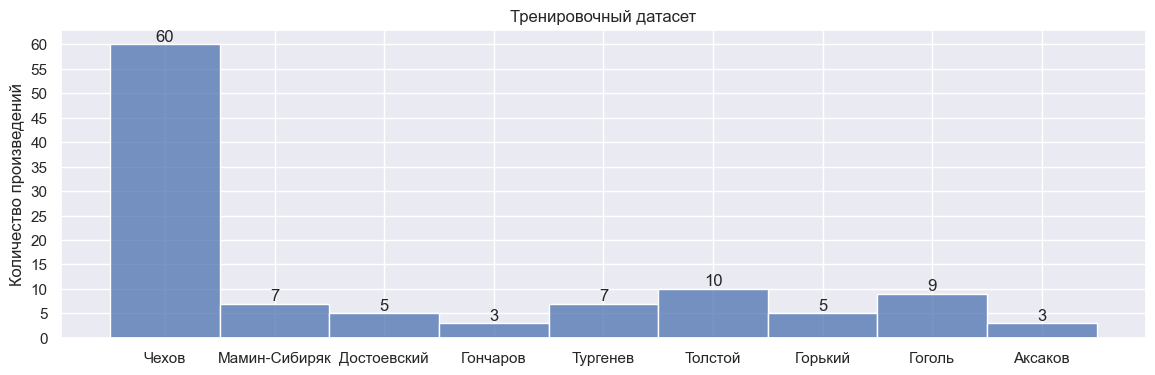

In [6]:
show_work_titles_histplot(df_train_raw, title='Тренировочный датасет')

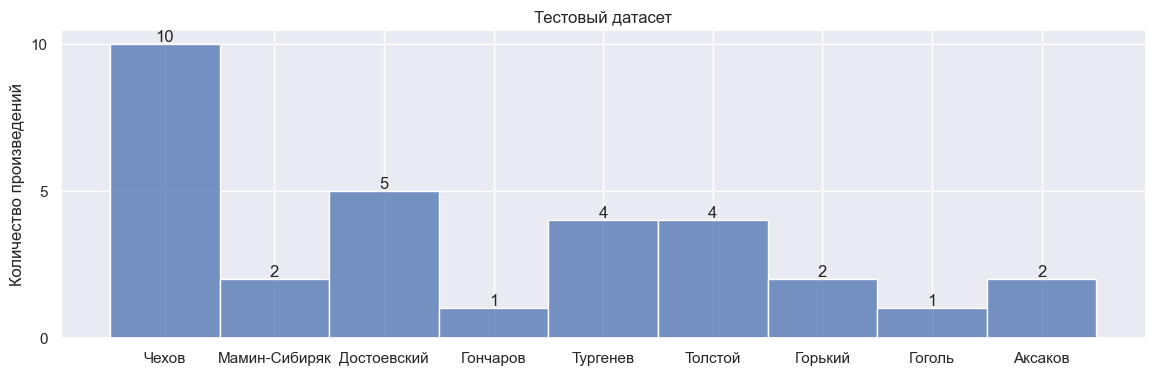

In [7]:
show_work_titles_histplot(df_test_raw, title='Тестовый датасет')

In [8]:
df_train_raw.sample(3)

,author,author_surname,work_title,text
78,ivan-turgenev,Тургенев,rudin,I Было тихое летнее утро. Солнце уже довольно ...
10,anton-chekhov,Чехов,beseda-pyanogo-s-trezvym-chertom,Беседа пьяного с трезвым чёртом Бывший чиновн...
4,anton-chekhov,Чехов,ariadna,"Ариадна На палубе парохода, шедшего из Одессы ..."


### Разбиение произведений на отрывки по $\approx250$ слов

Для разбиения текста написан генератор отрывков `excerpt_generator`. Отрывок подбирается так, чтобы первое и последнее предложения в нем входили в него целиком. Первый аргумент — разбиваемый текст, второй — минимальная длина отрывка в словах, третий — отступ (в словах) начала очередного отрывка от начала предыдущего (если отступ меньше длины отрывка, то отрывки пересекаются; чем меньше отступ — тем больше отрывков). Пример разбиения текста:

In [9]:
example = "\n... Раз. Два! Три? Четыре… Пять?! "+\
          "Шесть, семь, восемь, девять. Десять!!! Одиннадцать..."+\
          "Двенадцать, тринадцать, четырнадцать. Пятнадцать."
list(excerpt_generator(example, 2, 1))

['Раз. Два!',
 'Два! Три?',
 'Три? Четыре…',
 'Четыре… Пять?!',
 'Пять?! Шесть, семь, восемь, девять.',
 'Шесть, семь, восемь, девять.',
 'Десять!!! Одиннадцать...',
 'Одиннадцать... Двенадцать, тринадцать, четырнадцать.',
 'Двенадцать, тринадцать, четырнадцать.']

Чтобы получить больше данных для обучения, для тренировочного датасета установим отступ в 50 слов. Для тестового датасета, вероятно, правильнее будет установить отступ, равный длине отрывка (250 слов), чтобы отрывки получились разнородные (не пересекались) и не искажали оценку модели.

In [10]:
df_train = make_dataset_of_excerpts(df_train_raw, 250, offset=OFFSET)
df_test = make_dataset_of_excerpts(df_test_raw, 250, offset='excerpt_len')

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.84it/s]


In [11]:
df_train.to_csv(f'datasets/TRAIN_250words_offset{OFFSET}.csv', index=False)
df_test.to_csv(f'datasets/TEST_250words_offset250.csv', index=False)

In [12]:
df_train = pd.read_csv(f'datasets/TRAIN_250words_offset{OFFSET}.csv')
df_test = pd.read_csv(f'datasets/TEST_250words_offset250.csv')

In [13]:
df_train.shape

(81185, 5)

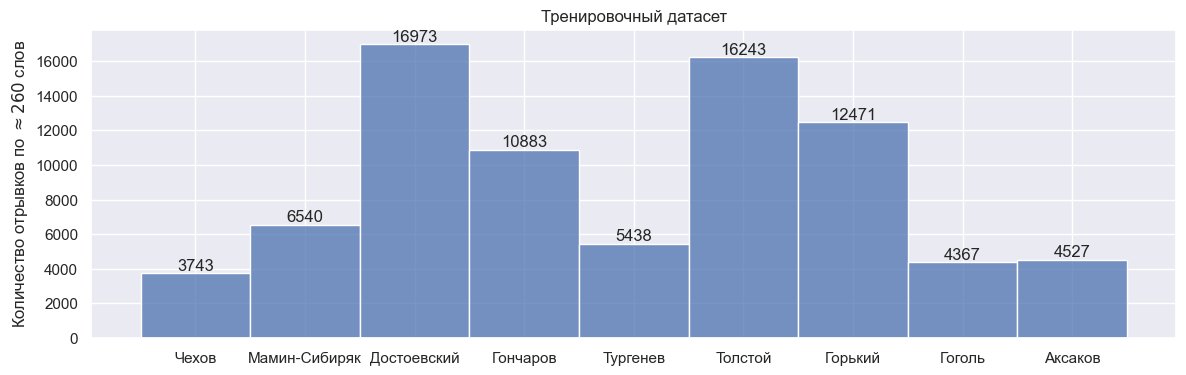

In [14]:
show_excerpts_histplot(df_train, 'Тренировочный датасет')

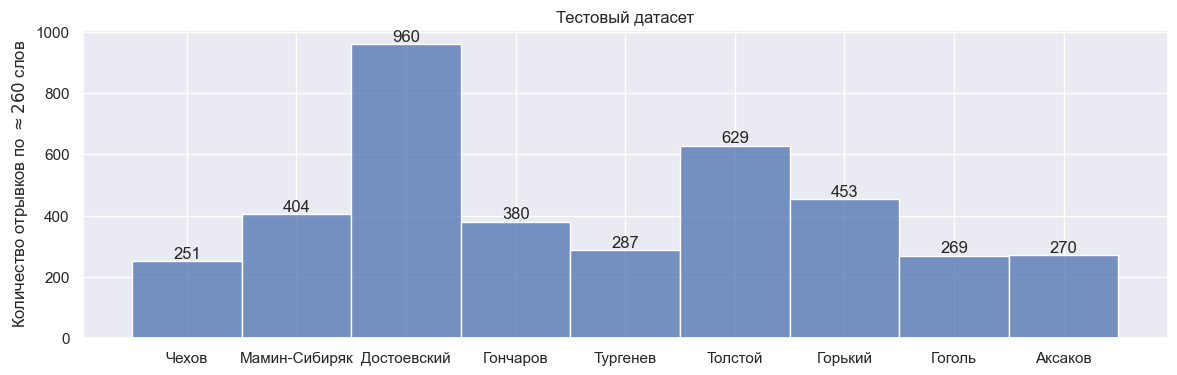

In [15]:
show_excerpts_histplot(df_test, 'Тестовый датасет')

In [16]:
df_test.shape

(3903, 5)

In [17]:
df_test.sample(5)

,author,author_surname,work_title,excerpt_num,text
2436,lev-tolstoi,Толстой,kazaki,36,"Еще дальше и вода, и берег, и туча — все слива..."
1707,ivan-goncharov,Гончаров,obyknovennaya-istoriya,92,"Ее одевают в газ, в блонды, убирают цветами и,..."
1728,ivan-goncharov,Гончаров,obyknovennaya-istoriya,113,"да! бесполезными, а между тем в те минуты душа..."
1610,fedor-dostoevskii,Достоевский,prestuplenie-i-nakazanie,673,Никогда не считали непоколебимее своих пригово...
1266,fedor-dostoevskii,Достоевский,prestuplenie-i-nakazanie,329,"И уж прижму ж я его, по-родственному ; пусть в..."


### Добавление столбца с леммами 

In [18]:
# Поддерживается многопоточность (`n_jobs` - число потоков).
for df in [df_train, df_test]:
    add_lemmas_column(df, inplace=True, verbose=1, n_jobs=10)

100%|███████████████████████████████████████████████████████████████████████████| 81185/81185 [04:18<00:00, 314.53it/s]
C:\Users\Grok\Documents\НИУ ВШЭ\МОВС\1 курс\Проект\utils.py:296: UserWarning: Не все тексты удалось лемматизировать. Возможно, они полностью состоят из стоп-слов или написаны латиницей. Тексты с NaN-значениями в столбце lemmas были удалены.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████| 3903/3903 [00:16<00:00, 239.30it/s]


In [19]:
df_train.to_csv(f'datasets/TRAIN_250words_lemmatized_offset{OFFSET}.csv', index=False)
df_test.to_csv(f'datasets/TEST_250words_lemmatized_offset250.csv', index=False)

In [20]:
df_train = pd.read_csv(f'datasets/TRAIN_250words_lemmatized_offset{OFFSET}.csv')
df_test = pd.read_csv(f'datasets/TEST_250words_lemmatized_offset250.csv')

In [21]:
df_train.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
30676,ivan-goncharov,Гончаров,fregat-pallada,3420,Занять иных образцов неоткуда. Все собственные...,занять иной образец неоткуда собственный источ...
46745,lev-tolstoi,Толстой,anna-karenina,3168,"Он улыбнулся, однако, и подошел к Кити. — Ну, ...",улыбнуться однако подойти кить спросить самый ...
3065,anton-chekhov,Чехов,tri-sestry,158,"Сегодня я играть не стану, только так посижу. ...",сегодня играть стать посидеть нездоровиться де...


In [22]:
df_test.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
1863,ivan-goncharov,Гончаров,obyknovennaya-istoriya,248,Когда он вошел… невозможно описать этого взгля...,войти невозможно описать взгляд который встрет...
2939,maksim-gorkii,Горький,foma-gordeev,28,"А лоцман-то новый уж, — объявил Фома. — Знаем…...",лоцман новый объявить фома знать добрый здоров...
3326,maksim-gorkii,Горький,moi-universitety,101,"Отец проклял его за строптивость и, проходя ми...",отец проклясть строптивость проходить мимо нов...


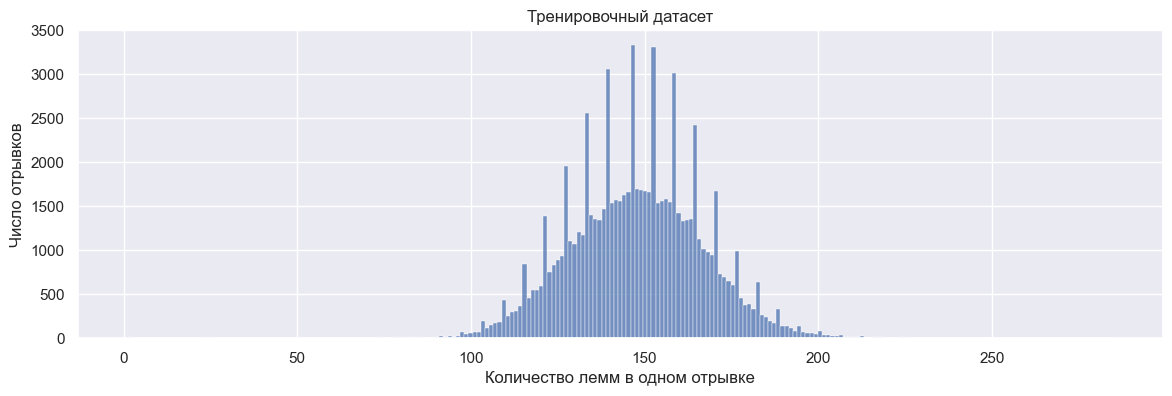

In [23]:
show_lemmas_histplot(df_train, 'Тренировочный датасет')

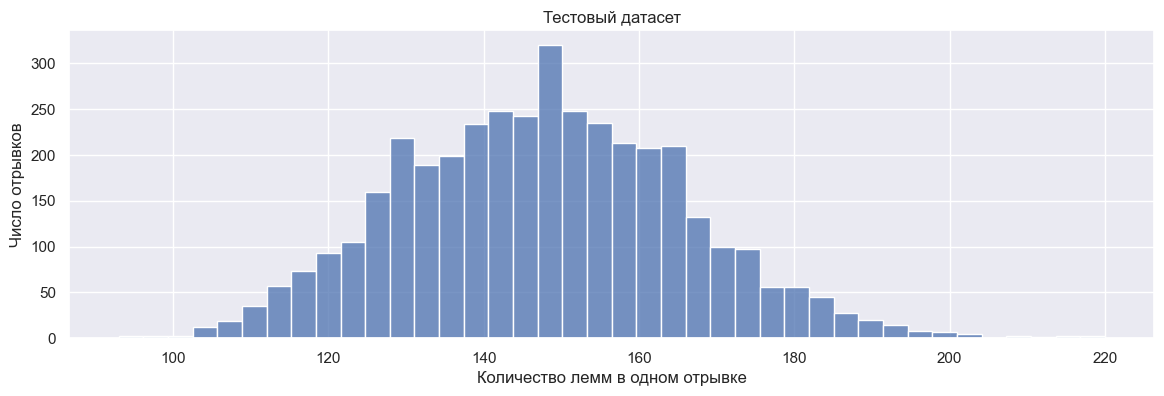

In [24]:
show_lemmas_histplot(df_test, 'Тестовый датасет')

## Обучение и оценка модели

Обучаем модель с помощью класса-пайплайна `AuthorIdentificationTfidfPipeline` из `tfidf_utils.py`.

In [4]:
df_train = pd.read_csv(f'datasets/TRAIN_250words_lemmatized_offset{OFFSET}.csv')
df_test = pd.read_csv(f'datasets/TEST_250words_lemmatized_offset250.csv')

In [5]:
# Инициализируем пайплайн-классификатор
pipe = tfidf.AuthorIdentificationTfidfPipeline(
    char_tfidf_params={'max_features': None},
    lemma_tfidf_params={'max_features': None}
)

Методу *fit* передается либо один аргумент: датафрейм **X**, если в нем есть столбец *author*; 

либо два аргумента: датафрейм **X** без стобца *author* и столбец **y** с авторами.

In [6]:
%%time
pipe.fit(df_train)

CPU times: total: 5min 35s
Wall time: 3min 56s


In [7]:
%%time
pred_test = pipe.predict(df_test)

CPU times: total: 10.9 s
Wall time: 11 s


#### F1-score

In [8]:
f1_score(df_test.author, pred_test, average='weighted')

0.9425376551757864

#### Для сравнения, простейший бейзлайн (мажоритарный класс)

In [30]:
def baseline(df_train, df_test):
    pred = df_train.groupby(by='author').count()['text'].idxmax()
    return [pred for i in range(df_test.shape[0])]

In [31]:
pred_test_baseline = baseline(df_train, df_test)
f1_score(df_test.author, pred_test_baseline, average='weighted')

0.09711127159338828

#### Confusion matrix

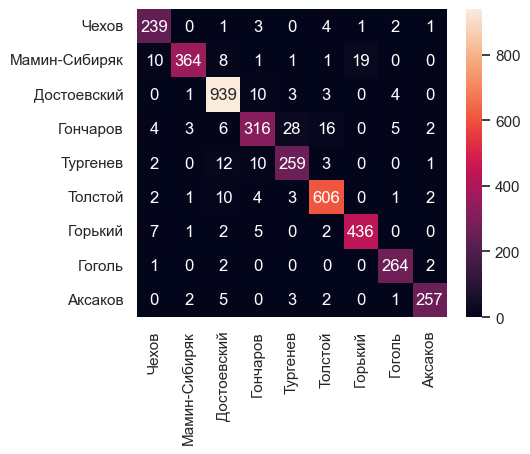

In [11]:
plot_confusion_matrix(df_test.author, pred_test, author_rus_surnames(df_train))

Чтобы получить более читаемую матрицу ошибок, сгенерируем сбалансированный тестовый датасет: с помощью функции `undersampling` удалим из имеющегося датасета случайные тексты у каждого автора в количестве, необходимом для уравнивания численности классов. Сделаем так три раза (на разных подмножествах).

0.9380309633987081


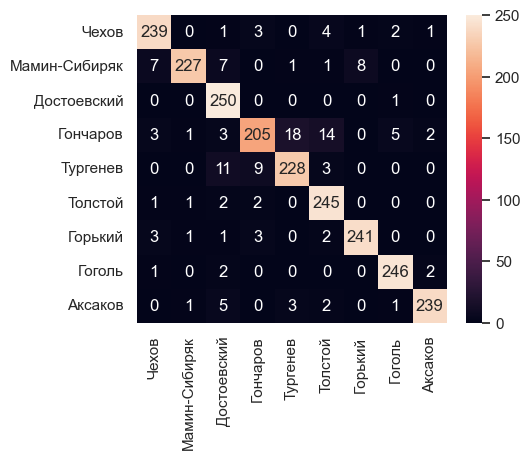

0.9360610991332724


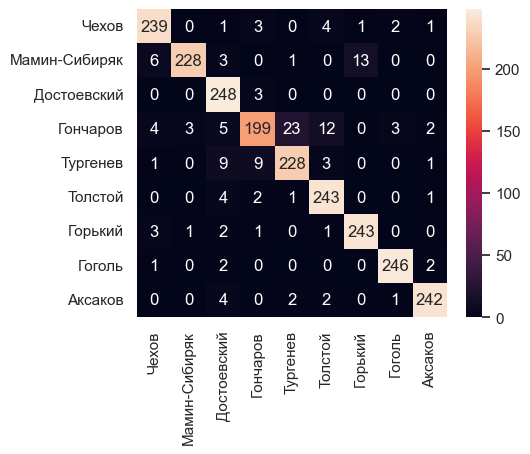

0.930624986740446


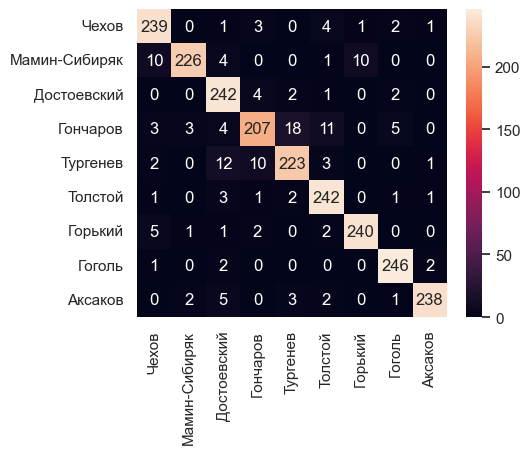

CPU times: total: 19.2 s
Wall time: 19.2 s


In [33]:
%%time
for i in range(3):
    df_test_u = undersampling(df_test)
    pred_test_u = pipe.predict(df_test_u)
    print(f1_score(df_test_u.author, pred_test_u, average='weighted'))
    plot_confusion_matrix(df_test_u.author, pred_test_u, author_rus_surnames(df_train))

В целом, результаты неплохие; заметные проблемы есть только с классификацией текстов Гончарова: автором его текстов модель иногда считает Тургенева. Лучше всего модель узнает Гоголя и Достоевского.

#### Список ошибочно классифицированных объектов

In [34]:
fp = false_predictions(df_test, pred_test)
print(fp.shape)
fp.sample(5)

(223, 7)


,y_true,y_pred,author_surname,work_title,excerpt_num,text,lemmas
1748,ivan-goncharov,ivan-turgenev,Гончаров,obyknovennaya-istoriya,133,"Помните, вы обещали что-то: ""Peau de chagrin"" ...",помнить обещать ждать ждать разлюбить думать а...
2750,lev-tolstoi,fedor-dostoevskii,Толстой,yunost,28,"Вишь, какой франт! — прибавил он не громко, но...",вишь франт прибавить громко слышать слово выхо...
448,dmitriy-mamin-sibiryak,anton-chekhov,Мамин-Сибиряк,cherty-iz-zhizni-pepko,197,"Автор должен ее придумывать, прикрашивать, сда...",автор должный придумывать прикрашивать сдабрив...
2154,ivan-turgenev,fedor-dostoevskii,Тургенев,nakanune,49,Я пытался его расспрашивать — не тут-то было. ...,пытаться расспрашивать отвечать общий фраза уж...
721,fedor-dostoevskii,nikolai-gogol,Достоевский,bednye-lyudi,66,"Событие прямо из времен Ивана Грозного, как вы...",событие прямо время иван грозный видеть разгов...


### Для сравнения, один из классических методов (Дельта Бёрроуза)

In [35]:
from burrows_delta import Corpus
import burrows_delta

train_crp = Corpus(
    authors=df_train.author.to_list(), 
    books=df_train.apply(lambda row: f'{row.work_title}_{row.excerpt_num}', axis=1).to_list(), 
    tokens=df_train.lemmas.to_list()
)

test_crp = Corpus(
    authors=df_test.author.to_list(), 
    books=df_test.apply(lambda row: f'{row.work_title}_{row.excerpt_num}', axis=1).to_list(), 
    tokens=df_test.lemmas.to_list()
)

In [36]:
%%time
df_b_delta = burrows_delta.calculate_burrows_delta(train_crp, test_crp, vocab_size=5000)
pred_test_b_delta = df_b_delta.T.columns[df_b_delta.apply(np.argmin, axis=0)]

CPU times: total: 43.9 s
Wall time: 44 s


In [37]:
f1_score(df_test.author, pred_test_b_delta, average='weighted')

0.25017354384565027

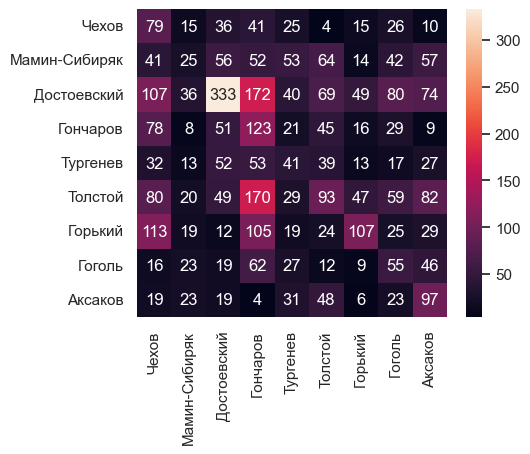

In [38]:
plot_confusion_matrix(df_test.author, pred_test_b_delta, author_rus_surnames(df_train))

## Качество бинарной классификации

In [11]:
df_train.author.unique()

array(['anton-chekhov', 'dmitriy-mamin-sibiryak', 'fedor-dostoevskii',
       'ivan-goncharov', 'ivan-turgenev', 'lev-tolstoi', 'maksim-gorkii',
       'nikolai-gogol', 'sergey-aksakov'], dtype=object)

In [16]:
def binary_clf_experiments(author1):
    xx_yy_list = []
    for author2 in df_train.author.unique():
        if author2 != author1:
            xx, yy = experiments__score_n_samples(
                pipe, df_train, df_test, [author1, author2]
            )
            xx_yy_list.append((xx, yy))
    return xx_yy_list

In [17]:
chekhov_ = binary_clf_experiments('anton-chekhov')

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [01:09<00:00,  1.27s/it]


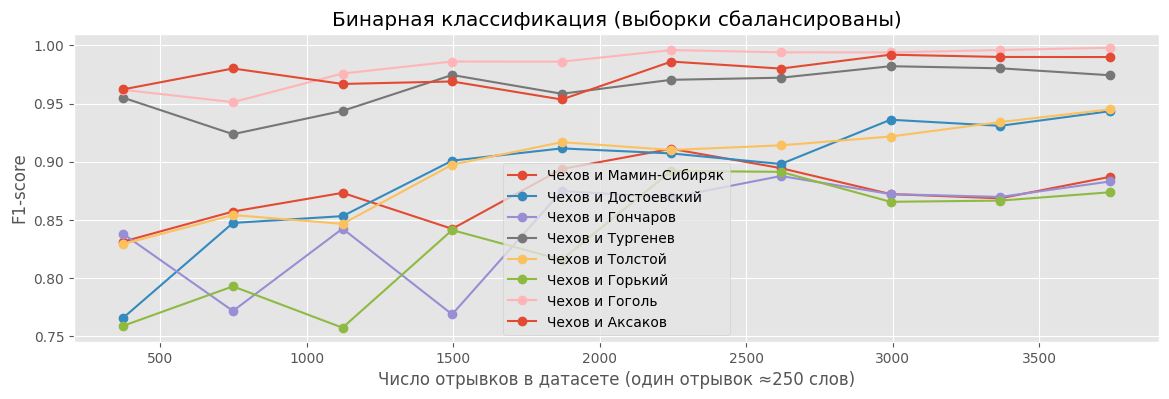

In [25]:
plt.figure(figsize=(14, 4))
plt.title("Бинарная классификация (выборки сбалансированы)")
plt.xlabel("Число отрывков в датасете (один отрывок ≈250 слов)")
plt.ylabel("F1-score")
i = 0
for author2 in df_train.author_surname.unique():
    if author2 != "Чехов":
        plt.plot(chekhov_[i][0], chekhov_[i][1], '-o', label=f"Чехов и {author2}")
        i += 1
plt.legend()
plt.show();